Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# Correlation & Association

* The correlation between numerical variables
* The association between categorical variables
* The association between numerical and categorical variables
* References
  * How does each method work and theresholds: http://www.ce.memphis.edu/7012/L17_CategoricalVariableAssociation.pdf
  * Why I didn't use Bonferroni correction for cat features association:
    * How does Bonferroni correction work: https://towardsdatascience.com/an-overview-of-the-multiple-comparison-problem-166aa5fcaac5
      * And Bonferroni-Holm correction is trying to address the drawback of Bonferroni correction
    * The drawbacks of using Bonferroni correction: https://medium.com/@ritesh.110587/correlation-between-categorical-variables-63f6bd9bf2f7
      * Can decrease type I error but can increase type II error
  * To check the correlation & association between variables, [point-biserial correlation is used when your cat variable only has 2 distinct values][1]
  
[1]:https://stats.stackexchange.com/questions/484299/how-to-check-the-correlation-between-categorical-and-numeric-independent-variabl

In [1]:
import pandas as pd
import numpy as np
import timeit
from scipy.stats import pearsonr, chi2_contingency, contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import f_oneway

import matplotlib.pyplot as plt
import seaborn as sbn

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings(action="ignore", category=DeprecationWarning)

In [2]:
raw_df = pd.read_pickle('../../crystal_ball/data_collector/structured_data/campaign_deposit.pkl')
print(raw_df.shape)

raw_df.head()

(11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,1


In [3]:
num_cols = [col for col in raw_df.columns if raw_df[col].dtype != 'O']
cat_cols = [col for col in raw_df.columns if raw_df[col].dtype == 'O']
print(len(num_cols), len(cat_cols))

print(num_cols)
print(cat_cols)

num_df = raw_df[num_cols]
cat_df = raw_df[cat_cols]

8 9
['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'deposit']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


## Correlation between Numerical Variables

* 2D correlation
* Multicollineary
* Both won't be affetced by data scaling

In [4]:
def visualize_2dcorr(df, corr_method='pearson', abs_corr=True):
    """
    Visualize the correlation between every 2 variables.
    :param corr_method: ‘pearson’, ‘kendall’, ‘spearman’
    :param abs_corr: decides whether to show absolute correlation or not
    """
    plt.figure(figsize=(10, 5))
    if abs_corr == True:
        mask = np.triu(np.ones_like(num_df.corr(method=corr_method).abs()))
        dataplot = sbn.heatmap(round(num_df.corr(method=corr_method).abs(), 3), mask=mask, annot=True)
    else:
        mask = np.triu(np.ones_like(num_df.corr(method=corr_method)))
        dataplot = sbn.heatmap(round(num_df.corr(method=corr_method), 3), mask=mask, annot=True)
        
    plt.show()
    

def get_num_correlated_features(df, corr_method='pearson', threshold=0.9, exclude_cols=[]):
    """
    Find correlated feature pairs. Higher threshold, higher correlation.
    :param corr_method: ‘pearson’, ‘kendall’, ‘spearman’
    :param threshold: the correlation threshold decides which feature pairs are highly correlated, abs value between 0..1 range
    """
    corr_dct = {}
    
    corr_matrix = df.corr(method=corr_method).abs()  # create correlation matrix
    upper_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))  # upper triangle
    
    for col in df.columns:
        if col in exclude_cols:
            continue
        corr_lst = list(upper_matrix[col].where(upper_matrix[col] >= threshold).dropna().index)
        if len(corr_lst) > 0:
            corr_dct.setdefault(col, [])
            corr_dct[col].extend(corr_lst)
    
    drop_lst = [column for column in upper_matrix.columns if any(upper_matrix[column] > threshold)]

    return corr_dct, drop_lst


def get_multicollineary_features(df, vif_threshold=10, exclude_cols=[]):
    """
    VIF (Variance Inflation Factor) measures how much the behavior (variance) of an independent variable is influenced, 
        or inflated by its interaction/correlation with the other independent variables.
    """
    cols = [col for col in df.columns if col not in exclude_cols]
    feature_df = df[cols].fillna(-999)
    
    vif_df = pd.DataFrame()
    vif_df["VIF Factor"] = [variance_inflation_factor(feature_df.values, i) for i in range(feature_df.shape[1])]
    vif_df["features"] = feature_df.columns  # This will get VIF for each feature.
    vif_df = vif_df.sort_values(by='VIF Factor', ascending=False)
    drop_lst = vif_df.loc[vif_df['VIF Factor']>vif_threshold]['features'].values
    return vif_df, list(drop_lst)

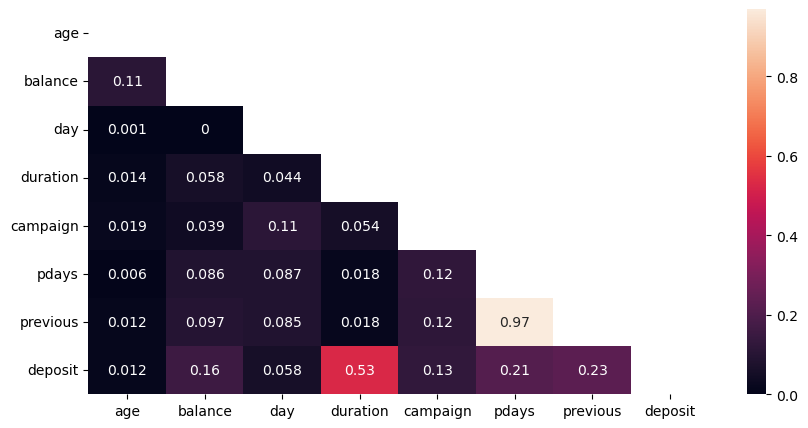

In [5]:
# show absolute correlation
visualize_2dcorr(num_df, corr_method='spearman', abs_corr=True)

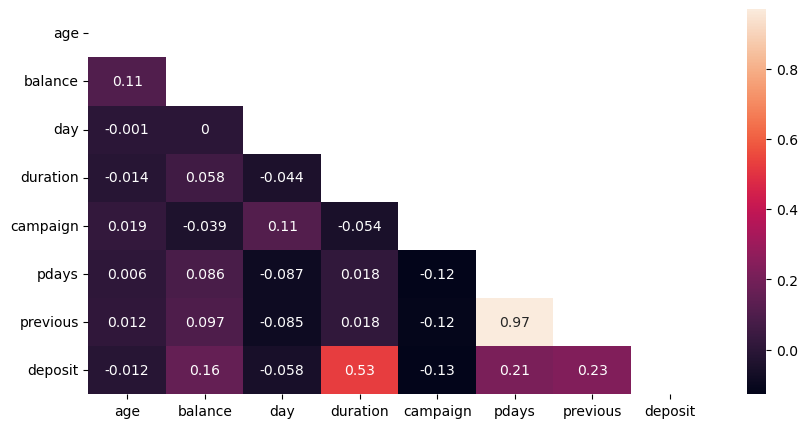

In [6]:
# show non-absolute correlation
visualize_2dcorr(num_df, corr_method='spearman', abs_corr=False)

In [7]:
# 2D correlation
corr_2d_dct, corr_2d_drop_lst = get_num_correlated_features(num_df, corr_method='spearman', threshold=0.6)
for col, corr_lst in corr_2d_dct.items():
    print(col, corr_lst)
print()
print(f'Drop List: {corr_2d_drop_lst}')

previous ['pdays']

Drop List: ['previous']


In [8]:
# multicollineary
vif_df, mulco_drop_lst = get_multicollineary_features(num_df, vif_threshold=5)
display(vif_df)

print(mulco_drop_lst)

,VIF Factor,features
0,5.029398,age
2,3.770683,day
3,2.645333,duration
7,2.511934,deposit
4,1.853042,campaign
5,1.659929,pdays
6,1.538593,previous
1,1.248767,balance


['age']


## Association between Categorical Variables

* Chi2 Contingency
* Cramer V
  * If a feature has very high missing rate, better to fill NA with a value before using Cramer V, otherwise will get errors

#### Note
* Be careful to apply these methods on high cardinality features, it might take large computational time and space. 
  * High cardinality can be `disintct value count / total value count >= 8%`

In [9]:
def get_cat_association(df, method='chi2', p_threshold=0.05):
    asso_lst = []
    cat_cols = df.columns
    
    start = timeit.default_timer()
    for i in range(len(cat_cols)-1):
        for j in range(i+1, len(cat_cols)):
            # Fill NA with 'NA' so that cramerv won't throw error when a feature's missing rate is high
            contingency_table = pd.crosstab(df[cat_cols[i]].fillna('NA'), df[cat_cols[j]].fillna('NA'))
            
            if method == 'chi2':
                test_static, p, dof, expected_feq = chi2_contingency(contingency_table)
                asso_result = 'associated' if p <= p_threshold else 'not associated'
            elif method == 'cramer':
                asso_result = contingency.association(contingency_table, method='cramer')
            else:
                print('"method" has to be "chi2" or "cramer"')
                return None
                
            asso_lst.append([cat_cols[i], cat_cols[j], asso_result])
            
    asso_df = pd.DataFrame(asso_lst, columns=['var1', 'var2', method])
    print(round(timeit.default_timer() - start, 4), "seconds")
    return asso_df

In [10]:
# using chi2 contigency
chi2_asso_df = get_cat_association(cat_df, method='chi2', p_threshold=0.05)
chi2_asso_df

0.6762 seconds


,var1,var2,chi2
0,job,marital,associated
1,job,education,associated
2,job,default,associated
3,job,housing,associated
4,job,loan,associated
5,job,contact,associated
6,job,month,associated
7,job,poutcome,associated
8,marital,education,associated
9,marital,default,not associated


In [11]:
# using Cramer V
cramer_asso_df = get_cat_association(cat_df, method='cramer')
cramer_asso_df.sort_values(by='cramer', ascending=False)

0.6505 seconds


,var1,var2,cramer
28,housing,month,0.476735
1,job,education,0.463411
33,contact,month,0.460565
3,job,housing,0.310399
27,housing,contact,0.260481
0,job,marital,0.237119
34,contact,poutcome,0.207636
35,month,poutcome,0.187564
5,job,contact,0.183559
31,loan,month,0.182041


It seems that, even the most correlated pairs here are weakly correlated ([Reference][1]).

[1]:http://www.ce.memphis.edu/7012/L17_CategoricalVariableAssociation.pdf

In [12]:
cat_asso_compare_df = chi2_asso_df.merge(cramer_asso_df, on=['var1', 'var2'])
cat_asso_compare_df.sort_values(by='cramer', ascending=False)

,var1,var2,chi2,cramer
28,housing,month,associated,0.476735
1,job,education,associated,0.463411
33,contact,month,associated,0.460565
3,job,housing,associated,0.310399
27,housing,contact,associated,0.260481
0,job,marital,associated,0.237119
34,contact,poutcome,associated,0.207636
35,month,poutcome,associated,0.187564
5,job,contact,associated,0.183559
31,loan,month,associated,0.182041


## Association between Categorical & Numerical Variables

* Examples showing how does ANOVA work on categorical variable:   
  * https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2613284/#:~:text=Interpretability%20of%20ANOVA%20over%20categorical,within%20and%20between%20the%20conditions.
  * http://www.sefidian.com/2021/07/02/measure-the-correlation-between-numerical-and-categorical-variables-and-the-correlation-between-two-categorical-variables-in-python-chi-square-and-anova/

In [13]:
def get_cat_num_association(all_df, cat_cols, num_cols, p_threshold=0.05):
    asso_lst = []
    
    for cat_col in cat_cols:
        for num_col in num_cols:
            df = all_df[[cat_col, num_col]]
            cat_group_lst = df.groupby(cat_col)[num_col].apply(list)
            anova_p = f_oneway(*cat_group_lst)[1]
            
            if anova_p <= p_threshold:
                asso = 'associated'
            else:
                asso = 'not cassociated'
            asso_lst.append([cat_col, num_col, asso])
            
    asso_df = pd.DataFrame(asso_lst, columns=['cat_variable', 'num_variable', 'association'])
    return asso_df

In [14]:
asso_df = get_cat_num_association(raw_df, cat_df.columns, num_df.columns, p_threshold=0.05)
asso_df

,cat_variable,num_variable,association
0,job,age,associated
1,job,balance,associated
2,job,day,not cassociated
3,job,duration,associated
4,job,campaign,associated
...,...,...,...
67,poutcome,duration,associated
68,poutcome,campaign,associated
69,poutcome,pdays,associated
70,poutcome,previous,associated
